In [1]:
import os
import json
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

class OCTDataset(Dataset):
    def __init__(self, root_dir, indices=None, train=True, is_gentuity=False, transform=None):
        
        self.root_dir = Path(root_dir)
        self.train = train
        self.is_gentuity = is_gentuity
        self.transform = transform
        
        if self.is_gentuity:
            # Gentuity dataset has separate train and test folders
            split_dir = "train" if self.train else "test"
            self.images_dir = self.root_dir / split_dir / "images"
            self.masks_dir = self.root_dir / split_dir / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        else:
            # Terumo dataset has only train data
            self.images_dir = self.root_dir / "train" / "images"
            self.masks_dir = self.root_dir / "train" / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        
        # Filter image paths using indices if provided
        if indices is not None:
            self.samples = [self.samples[i] for i in indices]
        
        else:
            self.samples = sorted(self.images_dir.glob("*.tiff"))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")  # Keep it as a PIL Image
        
        # Load the corresponding mask
        mask_path = self.masks_dir / f"{image_path.stem}.json"
        with open(mask_path, "r") as f:
            mask_data = json.load(f)
        
        # Create a binary mask (0 and 1 values)
        mask = np.zeros(image.size[::-1], dtype=np.uint8)  # image.size gives (width, height)
        for coord in mask_data["mask"]:
            x, y = coord
            if 0 <= x < mask.shape[0] and 0 <= y < mask.shape[1]:
                mask[x, y] = 1
        
        mask = Image.fromarray(mask)
        
        # Apply the transformation if available
        if self.transform:
            # Convert image and mask to Tensor
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Add channel dimension for mask
        mask = mask.unsqueeze(0) if len(mask.shape) == 2 else mask  # Add channel if needed

        unique_id = mask_data["unique_id"]
        
        return image, mask, image_path.stem, unique_id  # Returning image filename too

In [2]:
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute the attention weights
        attention = self.sigmoid(self.conv2(self.sigmoid(self.conv1(x))))
        return x * attention  # Element-wise multiplication

# Define a large U-Net model with Attn
class Net(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, initial_filters=64):
        super(Net, self).__init__()

        self.encoder1 = self.conv_block(input_channels, initial_filters)
        self.encoder2 = self.conv_block(initial_filters, initial_filters * 2)
        self.encoder3 = self.conv_block(initial_filters * 2, initial_filters * 4)
        self.encoder4 = self.conv_block(initial_filters * 4, initial_filters * 8)
        self.encoder5 = self.conv_block(initial_filters * 8, initial_filters * 16)

        self.pool = nn.MaxPool2d(2)

        # Adjusting channels to match attention input
        self.upconv5 = nn.ConvTranspose2d(initial_filters * 16, initial_filters * 8, kernel_size=2, stride=2)
        self.attn5 = AttentionBlock(initial_filters * 16)  # Updated input channels
        self.decoder5 = self.conv_block(initial_filters * 16, initial_filters * 8)

        self.upconv4 = nn.ConvTranspose2d(initial_filters * 8, initial_filters * 4, kernel_size=2, stride=2)
        self.attn4 = AttentionBlock(initial_filters * 8)  # Updated input channels
        self.decoder4 = self.conv_block(initial_filters * 8, initial_filters * 4)

        self.upconv3 = nn.ConvTranspose2d(initial_filters * 4, initial_filters * 2, kernel_size=2, stride=2)
        self.attn3 = AttentionBlock(initial_filters * 4)  # Updated input channels
        self.decoder3 = self.conv_block(initial_filters * 4, initial_filters * 2)

        self.upconv2 = nn.ConvTranspose2d(initial_filters * 2, initial_filters, kernel_size=2, stride=2)
        self.attn2 = AttentionBlock(initial_filters * 2)  # Updated input channels
        self.decoder2 = self.conv_block(initial_filters * 2, initial_filters)

        self.final_conv = nn.Conv2d(initial_filters, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        e5 = self.encoder5(self.pool(e4))

        # Decoding path with skip connections and attention
        d5 = torch.cat((self.upconv5(e5), e4), dim=1)
        d5 = self.attn5(d5)  # Apply attention
        d5 = self.decoder5(d5)

        d4 = torch.cat((self.upconv4(d5), e3), dim=1)
        d4 = self.attn4(d4)  # Apply attention
        d4 = self.decoder4(d4)

        d3 = torch.cat((self.upconv3(d4), e2), dim=1)
        d3 = self.attn3(d3)  # Apply attention
        d3 = self.decoder3(d3)

        d2 = torch.cat((self.upconv2(d3), e1), dim=1)
        d2 = self.attn2(d2)  # Apply attention
        d2 = self.decoder2(d2)

        # Final output layer
        out = self.final_conv(d2)

        return torch.sigmoid(out)  # Assuming binary segmentation

def dice_loss(pred, target, smooth=1.0):
    intersection = torch.sum(pred * target)
    return 1 - (2. * intersection + smooth) / (torch.sum(pred) + torch.sum(target) + smooth)

In [ ]:
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import neptune

def train_model_cv(config):
    
    # Initialize Neptune run
    run = neptune.init_run(
        project="OCTAA/OCTSegmenter",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MGU2NGNjMi0yNWE0LTRjNzgtOGNlNS1hZDdkMjJhYzYxMWUifQ==",
        name="training_and_validation",
        tags="terumo"
    )  # your credentials

    # Log configuration parameters
    run["parameters"] = config

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    net = Net().to(device)

    # Select optimizer based on the configuration
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=config["lr"])

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    root_dir = config["root_dir"]
    folds= config["folds"]
    
    with open(os.path.join(root_dir, "metadata.csv"), "r") as f:
        metadata_df = pd.read_csv(f)
        skf = StratifiedKFold(n_splits=folds)
        splits = list(skf.split(metadata_df, metadata_df["unique_id"]))

    fold = config["fold"]
    train_indices, val_indices = splits[fold]

    train_dataset = OCTDataset(root_dir, indices=train_indices, transform=transform)
    val_dataset = OCTDataset(root_dir, indices=val_indices, transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # Train and validate the model
    print(f"Training on fold {fold}")
    
    best_val_loss = float("inf")
    epochs = config["epochs"]
    no_improvement_epochs = 0
    patience = config["patience"]

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        epoch_steps= 0

        for i, data in enumerate(trainloader):
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            epoch_steps += 1
            if i % 10 == 9:  # print every 10 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                loss.item()))


        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(trainloader.dataset)
        run["train_loss"].append(train_loss)  # Log training loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

        # Validation phase
        net.eval()
        val_loss = 0.0

        with torch.no_grad():  # No need to calculate gradients during validation
            for data in valloader:
                images, masks, _, _ = data
                images, masks = images.to(device), masks.to(device)

                outputs = net(images)
                prediction = (outputs > 0.5).float()
                loss = dice_loss(prediction, masks)
                val_loss += loss.item() * images.size(0)
        
        # Calculate validation loss and accuracy
        val_loss = val_loss / len(valloader.dataset)
        run["val_loss"].append(val_loss)  # Log validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}")

        # Save checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
            print(f"Validation loss improved to {val_loss:.4f}. Saving checkpoint.")
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (net.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"loss": val_loss, "accuracy": 1 - val_loss},
                    checkpoint=checkpoint,
                )
        else:
            no_improvement_epochs += 1
            print(f"Validation loss did not improve. Best so far: {best_val_loss:.4f}")
        
        if no_improvement_epochs >= patience:
            print(f"Stopping early. No improvement in {patience} epochs.")
            run["early_stopping"] = True
            break

    run.stop()
    print("Finished Training")
    
def test_best_model(best_result):
    
    # Initialize Neptune run
    run = neptune.init_run(
        project="OCTAA/OCTSegmenter",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MGU2NGNjMi0yNWE0LTRjNzgtOGNlNS1hZDdkMjJhYzYxMWUifQ==",
        name="best_model_test",
        tags="gentuity"  
    )  # your credentials

    # Log configuration parameters
    run["parameters"] = best_result.config

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    best_trained_model = Net().to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
    best_trained_model.load_state_dict(model_state)

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"

    test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
    testloader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in testloader:
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            outputs = best_trained_model(images)
            predicted = (outputs > 0.5).float()
            loss = dice_loss(predicted, masks)
            total_loss += loss.item() * images.size(0)

    # Calculate average loss and accuracy
    total_loss /= len(testloader.dataset)
    accuracy = 1 - loss

    run["test_loss"] = total_loss
    run.stop()
    print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [4]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, cmap_data="tab10"):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # Mark the test samples
        indices[tr] = 0  # Mark the train samples

        # Visualize the results for the current split
        # Train samples in light blue, validation samples in redder orange
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=np.where(indices == 0, '#add8e6', '#ff4500'),  # Set light blue and redder orange
            marker="_",
            lw=lw,
        )

    # Plot the unique_id at the end (instead of class labels)
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Add a legend for train and validation splits
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#add8e6', lw=4, label='Train'),
        Line2D([0], [0], color='#ff4500', lw=4, label='Validation'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Formatting
    yticklabels = list(range(n_splits)) + ["unique_id"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title(f"{type(cv).__name__} Cross-Validation", fontsize=15)
    return ax

# Visualize splits
def visualize_cv_splits(metadata_df, n_splits=9):
    # Extract unique IDs and their corresponding target (unique_id)
    unique_ids = metadata_df["unique_id"].values

    # Initialize StratifiedKFold with n_splits
    skf = StratifiedKFold(n_splits=n_splits)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the cross-validation splits
    plot_cv_indices(
        skf, X=metadata_df, y=unique_ids, ax=ax, n_splits=n_splits
    )

    plt.show()

# Custom function to shorten trial directory names
def trial_dirname_creator(trial):
    # Shorten the trial name to only include key parameters
    return f"trial_{trial.trial_id}_lr={trial.config['lr']:.1e}_opt={trial.config['optimizer']}_bs={trial.config['batch_size']}"

def main(num_samples, gpus_per_trial, epochs, smoke_test, folds):
    if smoke_test:
        root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"
        with open(os.path.join(root_dir, "metadata.csv"), "r") as f:
            metadata_df = pd.read_csv(f)
            skf = StratifiedKFold(n_splits=folds)
            visualize_cv_splits(metadata_df, n_splits=folds)

    else:
        print("Using full dataset")
    
    config = {
        "root_dir": root_dir,
        "lr": 1e-4,
        "epochs": epochs,
        "smoke_test": smoke_test,
        "batch_size": tune.choice([2]),
        "optimizer": tune.grid_search(["Adam", "SGD", "RMSprop"]),
        "folds": folds,
        "fold": tune.grid_search(list(range(folds))),
        "patience": 10,
    }

    scheduler = ASHAScheduler(
        max_t=config["epochs"],
        grace_period=1,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model_cv),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=trial_dirname_creator,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=1, gpus_per_trial=1, epochs=5, smoke_test=True, folds=5)

(train_model_cv pid=7424) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-21
(train_model_cv pid=7424) Training on fold 0
(train_model_cv pid=7424) [1,    10] loss: 0.999
(train_model_cv pid=7424) [1,    20] loss: 0.999
(train_model_cv pid=7424) [1,    30] loss: 0.995
(train_model_cv pid=7424) [1,    40] loss: 0.999
(train_model_cv pid=7424) [1,    50] loss: 0.996
(train_model_cv pid=7424) [1,    60] loss: 0.998
(train_model_cv pid=7424) [1,    70] loss: 0.999
(train_model_cv pid=7424) Epoch [1/5], Training Loss: 0.9984
(train_model_cv pid=7424) Epoch [1/5], Validation Loss: 0.9931
(train_model_cv pid=7424) Validation loss improved to 0.9931. Saving checkpoint.


(train_model_cv pid=7424) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00000_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=7424) [2,    10] loss: 0.998
(train_model_cv pid=7424) [2,    20] loss: 0.999
(train_model_cv pid=7424) [2,    30] loss: 0.999
(train_model_cv pid=7424) [2,    40] loss: 0.999
(train_model_cv pid=7424) [2,    50] loss: 0.999
(train_model_cv pid=7424) [2,    60] loss: 0.998
(train_model_cv pid=7424) [2,    70] loss: 0.999
(train_model_cv pid=7424) Epoch [2/5], Training Loss: 0.9978
(train_model_cv pid=7424) Epoch [2/5], Validation Loss: 0.9928
(train_model_cv pid=7424) Validation loss improved to 0.9928. Saving checkpoint.


(train_model_cv pid=7424) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00000_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000001)


(train_model_cv pid=7424) [3,    10] loss: 0.998
(train_model_cv pid=7424) [3,    20] loss: 0.998
(train_model_cv pid=7424) [3,    30] loss: 0.995
(train_model_cv pid=7424) [3,    40] loss: 0.995
(train_model_cv pid=7424) [3,    50] loss: 0.998
(train_model_cv pid=7424) [3,    60] loss: 0.995
(train_model_cv pid=7424) [3,    70] loss: 0.998
(train_model_cv pid=7424) Epoch [3/5], Training Loss: 0.9974
(train_model_cv pid=7424) Epoch [3/5], Validation Loss: 0.9934
(train_model_cv pid=7424) Validation loss did not improve. Best so far: 0.9928
(train_model_cv pid=7424) [4,    10] loss: 0.995
(train_model_cv pid=7424) [4,    20] loss: 0.998
(train_model_cv pid=7424) [4,    30] loss: 0.994
(train_model_cv pid=7424) [4,    40] loss: 0.997
(train_model_cv pid=7424) [4,    50] loss: 0.997
(train_model_cv pid=7424) [4,    60] loss: 1.000
(train_model_cv pid=7424) [4,    70] loss: 0.998
(train_model_cv pid=7424) Epoch [4/5], Training Loss: 0.9970
(train_model_cv pid=7424) Epoch [4/5], Validation 

(train_model_cv pid=7424) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00000_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000002)


(train_model_cv pid=7424) [neptune] [info   ] Shutting down background jobs, please wait a moment...
(train_model_cv pid=7424) [neptune] [info   ] Done!
(train_model_cv pid=7424) [neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
(train_model_cv pid=7424) [neptune] [info   ] All 2 operations synced, thanks for waiting!
(train_model_cv pid=7424) [neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-21/metadata
(train_model_cv pid=7424) Finished Training
(train_model_cv pid=28820) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-22
(train_model_cv pid=28820) Training on fold 1
(train_model_cv pid=28820) [1,    10] loss: 0.999
(train_model_cv pid=28820) [1,    20] loss: 0.999
(train_model_cv pid=28820) [1,    30] loss: 0.997
(train_model_cv pid=28820) [1,    40] loss: 0.996
(train_model_cv pid=28820) [1,    50] loss:

(train_model_cv pid=28820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00001_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=28820) [2,    10] loss: 0.996
(train_model_cv pid=28820) [2,    20] loss: 0.999
(train_model_cv pid=28820) [2,    30] loss: 1.000
(train_model_cv pid=28820) [2,    40] loss: 0.995
(train_model_cv pid=28820) [2,    50] loss: 0.995
(train_model_cv pid=28820) [2,    60] loss: 0.999
(train_model_cv pid=28820) [2,    70] loss: 0.998
(train_model_cv pid=28820) Epoch [2/5], Training Loss: 0.9980
(train_model_cv pid=28820) Epoch [2/5], Validation Loss: 0.9930
(train_model_cv pid=28820) Validation loss did not improve. Best so far: 0.9922
(train_model_cv pid=28820) [3,    10] loss: 0.999
(train_model_cv pid=28820) [3,    20] loss: 0.999
(train_model_cv pid=28820) [3,    30] loss: 0.998
(train_model_cv pid=28820) [3,    40] loss: 0.995
(train_model_cv pid=28820) [3,    50] loss: 0.995
(train_model_cv pid=28820) [3,    60] loss: 0.999
(train_model_cv pid=28820) [3,    70] loss: 0.999
(train_model_cv pid=28820) Epoch [3/5], Training Loss: 0.9977
(train_model_cv pid=28820) Epoch

(train_model_cv pid=22080) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00002_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=28408) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-24
(train_model_cv pid=28408) Training on fold 3
(train_model_cv pid=28408) [1,    10] loss: 0.999
(train_model_cv pid=28408) [1,    20] loss: 0.999
(train_model_cv pid=28408) [1,    30] loss: 0.999
(train_model_cv pid=28408) [1,    40] loss: 0.999
(train_model_cv pid=28408) [1,    50] loss: 0.999
(train_model_cv pid=28408) [1,    60] loss: 0.998
(train_model_cv pid=28408) [1,    70] loss: 0.996
(train_model_cv pid=28408) Epoch [1/5], Training Loss: 0.9986
(train_model_cv pid=28408) Epoch [1/5], Validation Loss: 0.9945
(train_model_cv pid=28408) Validation loss improved to 0.9945. Saving checkpoint.


(train_model_cv pid=28408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00003_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=29520) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-25
(train_model_cv pid=29520) Training on fold 4
(train_model_cv pid=29520) [1,    10] loss: 0.999
(train_model_cv pid=29520) [1,    20] loss: 0.999
(train_model_cv pid=29520) [1,    30] loss: 0.999
(train_model_cv pid=29520) [1,    40] loss: 0.999
(train_model_cv pid=29520) [1,    50] loss: 0.999
(train_model_cv pid=29520) [1,    60] loss: 0.995
(train_model_cv pid=29520) [1,    70] loss: 0.999
(train_model_cv pid=29520) Epoch [1/5], Training Loss: 0.9983
(train_model_cv pid=29520) Epoch [1/5], Validation Loss: 0.9935
(train_model_cv pid=29520) Validation loss improved to 0.9935. Saving checkpoint.


(train_model_cv pid=29520) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00004_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=29520) [2,    10] loss: 0.998
(train_model_cv pid=29520) [2,    20] loss: 0.998
(train_model_cv pid=29520) [2,    30] loss: 0.998
(train_model_cv pid=29520) [2,    40] loss: 0.998
(train_model_cv pid=29520) [2,    50] loss: 0.999
(train_model_cv pid=29520) [2,    60] loss: 0.999
(train_model_cv pid=29520) [2,    70] loss: 0.995
(train_model_cv pid=29520) Epoch [2/5], Training Loss: 0.9978
(train_model_cv pid=29520) Epoch [2/5], Validation Loss: 0.9974
(train_model_cv pid=29520) Validation loss did not improve. Best so far: 0.9935
(train_model_cv pid=29520) [3,    10] loss: 0.998
(train_model_cv pid=29520) [3,    20] loss: 0.995
(train_model_cv pid=29520) [3,    30] loss: 0.999
(train_model_cv pid=29520) [3,    40] loss: 0.997
(train_model_cv pid=29520) [3,    50] loss: 0.997
(train_model_cv pid=29520) [3,    60] loss: 0.995
(train_model_cv pid=29520) [3,    70] loss: 0.994
(train_model_cv pid=29520) Epoch [3/5], Training Loss: 0.9974
(train_model_cv pid=29520) Epoch

(train_model_cv pid=29520) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00004_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000001)


(train_model_cv pid=26232) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-26
(train_model_cv pid=26232) Training on fold 0
(train_model_cv pid=26232) [1,    10] loss: 1.000
(train_model_cv pid=26232) [1,    20] loss: 0.998
(train_model_cv pid=26232) [1,    30] loss: 1.000
(train_model_cv pid=26232) [1,    40] loss: 0.999
(train_model_cv pid=26232) [1,    50] loss: 0.998
(train_model_cv pid=26232) [1,    60] loss: 0.998
(train_model_cv pid=26232) [1,    70] loss: 1.000
(train_model_cv pid=26232) Epoch [1/5], Training Loss: 0.9993
(train_model_cv pid=26232) Epoch [1/5], Validation Loss: 0.9994
(train_model_cv pid=26232) Validation loss improved to 0.9994. Saving checkpoint.


(train_model_cv pid=26232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00005_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=7840) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-27
(train_model_cv pid=7840) Training on fold 1
(train_model_cv pid=7840) [1,    10] loss: 1.000
(train_model_cv pid=7840) [1,    20] loss: 0.999
(train_model_cv pid=7840) [1,    30] loss: 0.998
(train_model_cv pid=7840) [1,    40] loss: 1.000
(train_model_cv pid=7840) [1,    50] loss: 0.999
(train_model_cv pid=7840) [1,    60] loss: 0.999
(train_model_cv pid=7840) [1,    70] loss: 0.999
(train_model_cv pid=7840) Epoch [1/5], Training Loss: 0.9991
(train_model_cv pid=7840) Epoch [1/5], Validation Loss: 0.9990
(train_model_cv pid=7840) Validation loss improved to 0.9990. Saving checkpoint.


(train_model_cv pid=7840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00006_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=23076) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-28
(train_model_cv pid=23076) Training on fold 2
(train_model_cv pid=23076) [1,    10] loss: 0.999
(train_model_cv pid=23076) [1,    20] loss: 1.000
(train_model_cv pid=23076) [1,    30] loss: 0.999
(train_model_cv pid=23076) [1,    40] loss: 1.000
(train_model_cv pid=23076) [1,    50] loss: 1.000
(train_model_cv pid=23076) [1,    60] loss: 0.999
(train_model_cv pid=23076) [1,    70] loss: 0.997
(train_model_cv pid=23076) Epoch [1/5], Training Loss: 0.9993
(train_model_cv pid=23076) Epoch [1/5], Validation Loss: 0.9980
(train_model_cv pid=23076) Validation loss improved to 0.9980. Saving checkpoint.


(train_model_cv pid=23076) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00007_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=6060) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-29
(train_model_cv pid=6060) Training on fold 3
(train_model_cv pid=6060) [1,    10] loss: 0.998
(train_model_cv pid=6060) [1,    20] loss: 0.999
(train_model_cv pid=6060) [1,    30] loss: 0.998
(train_model_cv pid=6060) [1,    40] loss: 0.998
(train_model_cv pid=6060) [1,    50] loss: 0.999
(train_model_cv pid=6060) [1,    60] loss: 1.000
(train_model_cv pid=6060) [1,    70] loss: 0.998
(train_model_cv pid=6060) Epoch [1/5], Training Loss: 0.9993
(train_model_cv pid=6060) Epoch [1/5], Validation Loss: 0.9987
(train_model_cv pid=6060) Validation loss improved to 0.9987. Saving checkpoint.


(train_model_cv pid=6060) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00008_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=29688) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-30
(train_model_cv pid=29688) Training on fold 4
(train_model_cv pid=29688) [1,    10] loss: 1.000
(train_model_cv pid=29688) [1,    20] loss: 0.999
(train_model_cv pid=29688) [1,    30] loss: 1.000
(train_model_cv pid=29688) 
(train_model_cv pid=29688) [1,    40] loss: 0.999
(train_model_cv pid=29688) [1,    50] loss: 1.000
(train_model_cv pid=29688) [1,    60] loss: 1.000
(train_model_cv pid=29688) [1,    70] loss: 1.000
(train_model_cv pid=29688) Epoch [1/5], Training Loss: 0.9993
(train_model_cv pid=29688) Epoch [1/5], Validation Loss: 0.9994
(train_model_cv pid=29688) Validation loss improved to 0.9994. Saving checkpoint.


(train_model_cv pid=29688) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00009_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=27712) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-31
(train_model_cv pid=27712) Training on fold 0
(train_model_cv pid=27712) [1,    10] loss: 0.999
(train_model_cv pid=27712) [1,    20] loss: 0.999
(train_model_cv pid=27712) [1,    30] loss: 0.999
(train_model_cv pid=27712) [1,    40] loss: 0.999
(train_model_cv pid=27712) [1,    50] loss: 0.998
(train_model_cv pid=27712) [1,    60] loss: 0.998
(train_model_cv pid=27712) [1,    70] loss: 0.998
(train_model_cv pid=27712) Epoch [1/5], Training Loss: 0.9982
(train_model_cv pid=27712) Epoch [1/5], Validation Loss: 0.9919
(train_model_cv pid=27712) Validation loss improved to 0.9919. Saving checkpoint.


(train_model_cv pid=27712) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00010_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=27712) [2,    10] loss: 0.999
(train_model_cv pid=27712) [2,    20] loss: 0.995
(train_model_cv pid=27712) [2,    30] loss: 0.995
(train_model_cv pid=27712) [2,    40] loss: 0.999
(train_model_cv pid=27712) [2,    50] loss: 0.999
(train_model_cv pid=27712) [2,    60] loss: 0.999
(train_model_cv pid=27712) [2,    70] loss: 0.999
(train_model_cv pid=27712) Epoch [2/5], Training Loss: 0.9975
(train_model_cv pid=27712) Epoch [2/5], Validation Loss: 0.9931
(train_model_cv pid=27712) Validation loss did not improve. Best so far: 0.9919
(train_model_cv pid=27712) [3,    10] loss: 0.998
(train_model_cv pid=27712) [3,    20] loss: 0.998
(train_model_cv pid=27712) [3,    30] loss: 0.995
(train_model_cv pid=27712) [3,    40] loss: 0.998
(train_model_cv pid=27712) [3,    50] loss: 0.995
(train_model_cv pid=27712) [3,    60] loss: 0.994
(train_model_cv pid=27712) [3,    70] loss: 0.995
(train_model_cv pid=27712) Epoch [3/5], Training Loss: 0.9971
(train_model_cv pid=27712) Epoch

(train_model_cv pid=7668) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00011_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=28568) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-33
(train_model_cv pid=28568) Training on fold 2
(train_model_cv pid=28568) [1,    10] loss: 0.999
(train_model_cv pid=28568) [1,    20] loss: 1.000
(train_model_cv pid=28568) [1,    30] loss: 0.998
(train_model_cv pid=28568) [1,    40] loss: 0.998
(train_model_cv pid=28568) [1,    50] loss: 0.998
(train_model_cv pid=28568) [1,    60] loss: 0.998
(train_model_cv pid=28568) [1,    70] loss: 0.998
(train_model_cv pid=28568) Epoch [1/5], Training Loss: 0.9981
(train_model_cv pid=28568) Epoch [1/5], Validation Loss: 0.9983
(train_model_cv pid=28568) Validation loss improved to 0.9983. Saving checkpoint.


(train_model_cv pid=28568) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00012_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=13596) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-34
(train_model_cv pid=13596) Training on fold 3
(train_model_cv pid=13596) [1,    10] loss: 0.999
(train_model_cv pid=13596) [1,    20] loss: 0.999
(train_model_cv pid=13596) [1,    30] loss: 0.999
(train_model_cv pid=13596) [1,    40] loss: 0.999
(train_model_cv pid=13596) [1,    50] loss: 0.999
(train_model_cv pid=13596) [1,    60] loss: 0.999
(train_model_cv pid=13596) [1,    70] loss: 0.999
(train_model_cv pid=13596) Epoch [1/5], Training Loss: 0.9983
(train_model_cv pid=13596) Epoch [1/5], Validation Loss: 0.9960
(train_model_cv pid=13596) Validation loss improved to 0.9960. Saving checkpoint.


(train_model_cv pid=13596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00013_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=13596) [2,    10] loss: 0.998
(train_model_cv pid=13596) [2,    20] loss: 0.999
(train_model_cv pid=13596) [2,    30] loss: 0.998
(train_model_cv pid=13596) [2,    40] loss: 0.998
(train_model_cv pid=13596) [2,    50] loss: 0.999
(train_model_cv pid=13596) [2,    60] loss: 0.998
(train_model_cv pid=13596) [2,    70] loss: 0.993
(train_model_cv pid=13596) Epoch [2/5], Training Loss: 0.9977
(train_model_cv pid=13596) Epoch [2/5], Validation Loss: 0.9939
(train_model_cv pid=13596) Validation loss improved to 0.9939. Saving checkpoint.


(train_model_cv pid=13596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00013_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000001)


(train_model_cv pid=27872) [neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-35
(train_model_cv pid=27872) Training on fold 4
(train_model_cv pid=27872) [1,    10] loss: 0.999
(train_model_cv pid=27872) [1,    20] loss: 0.999
(train_model_cv pid=27872) [1,    30] loss: 0.997
(train_model_cv pid=27872) [1,    40] loss: 0.998
(train_model_cv pid=27872) [1,    50] loss: 0.995
(train_model_cv pid=27872) [1,    60] loss: 0.999
(train_model_cv pid=27872) [1,    70] loss: 0.999
(train_model_cv pid=27872) Epoch [1/5], Training Loss: 0.9981
(train_model_cv pid=27872) Epoch [1/5], Validation Loss: 0.9973
(train_model_cv pid=27872) Validation loss improved to 0.9973. Saving checkpoint.


(train_model_cv pid=27872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19/trial_c16ba_00014_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)
2024-11-24 18:22:09,984	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/johan/ray_results/train_model_cv_2024-11-24_18-01-19' in 0.0640s.
2024-11-24 18:22:10,013	INFO tune.py:1041 -- Total run time: 1237.64 seconds (1237.43 seconds for the tuning loop).


Best trial config: {'root_dir': 'D:\\OneDrive - Aarhus Universitet\\9. Semester\\Deep Learning\\data_terumo_smoke_test', 'lr': 0.0001, 'epochs': 5, 'smoke_test': True, 'batch_size': 2, 'optimizer': 'RMSprop', 'folds': 5, 'fold': 0, 'patience': 10}
Best trial final validation loss: 0.9919383161597781
Best trial final validation accuracy: 0.008061683840221878


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-36
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/OCTAA/OCTSegmenter/e/OCT-36/metadata
Test Loss: 0.9978, Test Accuracy: 0.0009


Loading results from C:\Users\johan\ray_results\train_model_cv_2024-11-24_18-01-19...
No errors!
Number of results: 15
Trial #0 finished successfully with a loss of: 0.9939059615135193
Trial #1 finished successfully with a loss of: 0.994587262471517
Trial #2 finished successfully with a loss of: 0.9980228013462491
Trial #3 finished successfully with a loss of: 0.9968681269221835
Trial #4 finished successfully with a loss of: 0.9932986663447486
Trial #5 finished successfully with a loss of: 0.9990426997343699
Trial #6 finished successfully with a loss of: 0.9993633561664157
Trial #7 finished successfully with a loss of: 0.9919383161597781
Trial #8 finished successfully with a loss of: 0.9972858660750918
Trial #9 finished successfully with a loss of: 0.9993565811051263
Trial #10 finished successfully with a loss of: 0.9987093408902487
Trial #11 finished successfully with a loss of: 0.9982538455062442
Trial #12 finished successfully with a loss of: 0.9921639892790053
Trial #13 finished su

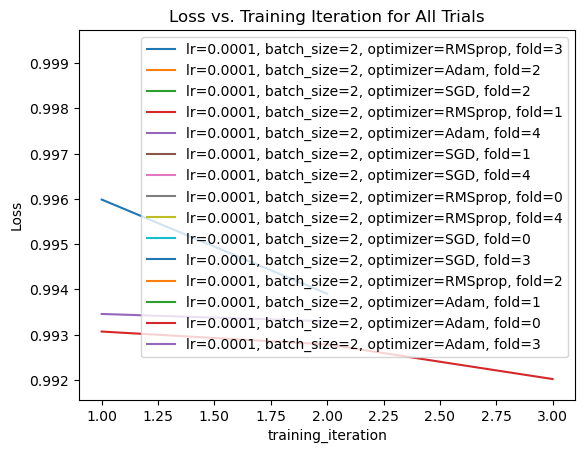

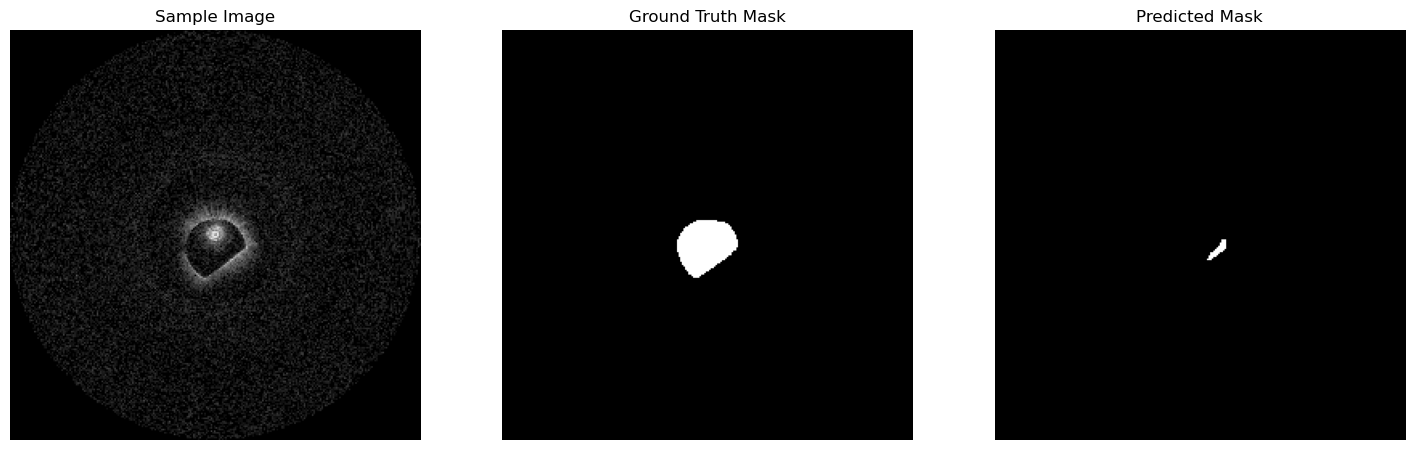

In [5]:
storage_path = r"C:\Users\johan\ray_results"
exp_name = "train_model_cv_2024-11-24_18-01-19"
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=train_model_cv)
result_grid = restored_tuner.get_results()

# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

num_results = len(result_grid)
print("Number of results:", num_results)

# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(f"Trial #{i} finished successfully with a loss of: {result.metrics['loss']}")

results_df = result_grid.get_dataframe()
results_df[["training_iteration", "loss"]]

print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.4f}, batch_size={result.config['batch_size']}, optimizer={result.config['optimizer']}, fold={result.config['fold']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "loss", ax=ax, label=label)
ax.set_title("Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Loss")

from ray.train import Result

# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

print("Best trial config: {}".format(best_result.config))

# Get the best trial's final loss and accuracy
best_loss = best_result.metrics["loss"]
print("Best trial final test set loss: {}".format(best_loss))
best_accuracy = best_result.metrics["accuracy"]
print("Best trial final test set accuracy: {}".format(best_accuracy))

# Load the best model
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

best_trained_model = Net().to(device)

# Load the best checkpoint
checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
best_trained_model.load_state_dict(model_state)

# Set the model to evaluation mode
best_trained_model.eval()

# Load a sample image from the test dataset
root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])
test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
random_indices = np.random.choice(len(test_dataset), 1, replace=False)
sample_image, sample_mask, _, _ = test_dataset[random_indices[0]]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = best_trained_model(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()